# Домашнее задание: Perception

В этом задании вам будет необходимо обучить PointNet для задачи фильтрации шума в лидарном облаке.

Задание:

1. Необходимо реализовать PointNet, который будет работать на данных со снегом. PointNet должен работать на окрестностях точек, нет смысла запускать его на всем облаке. PointNet должен включать в себя шаг агрегации по множеству: например с помощью функции максимума, шаг подклеивания агрегированного вектора к исходным точкам и шаг вычисления фичей по отдельным точкам. Вероятно вы захотите повторить эту процедуру несколько раз для улучшения качества. Статья: https://arxiv.org/abs/1612.00593. Вы можете выбрать любой фреймворк для реализации.
2. Ваш PointNet должен ограничить сверху размер окрестности. В референсной реализации использовались 64 точки.
3. Разбиение на train/test. Для разбиения используйте следующий код.
```
scene_indices = np.arange(0, 291)
np.random.seed(100)
np.random.shuffle(scene_indices)
train_indices = scene_indices[:260]
test_indices = scene_indices[260:]
```
4. Данные лучше генерировать on-demand, таким образом вам не придется хранить в памяти большие массивы точек. В tensorflow это можно реализовать через tf.data.

5. PointNet это функция, которая работает на неупорядоченном множестве точек. В нашем же кейсе мы не хотим предсказать свойство окрестности, мы хотим предсказать свойство точки. Подумайте о том как можно модифицировать архитектуру, чтобы pointnet "не забывал" фичи точки, которая нам интересна. (Это поможет улучшить качество)


## Формальные требования

1. В вашей архитектуре должны быть признаки PointNet: вычисление глобального вектора множества, подклеивание его обратно, вычисление фичей по точкам.

2. ROC-AUC на тестовом датасете должен превышать 0.99


In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.neighbors import KDTree
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from tqdm.notebook import tqdm_notebook
from IPython.display import clear_output

py.init_notebook_mode(connected=True)

EQUAL_ASPECT_RATIO_LAYOUT = dict(
    margin={
        'l': 0,
        'r': 0,
        'b': 0,
        't': 0
    }, scene=dict(
    aspectmode='data'
))

def color(x, cmap='Reds'):
    cmap = plt.get_cmap(cmap)
    x = (x - np.min(x)) / np.max(x)
    
    return cmap(x)

%matplotlib inline

In [2]:
ds = pd.read_csv('snow/snow.csv')
ds.head()

x         y         z  intensity  ring  scene_id  label
0 -11.355618 -4.206962  0.344085        0.0  23.0         0    1.0
1  -5.916535 -1.972164  0.283262        0.0  25.0         0    1.0
2  -7.410451 -2.113039  2.137792        0.0  31.0         0    1.0
3 -13.845870 -1.406652  0.406310        0.0  23.0         0    1.0
4  -8.326218 -0.346060  0.226469        0.0  22.0         0    1.0

In [3]:
class PointDataset(Dataset):
    def __init__(self, dataframe, num_neighbors):
        super().__init__()
        
        dataframe = dataframe.sort_values(by='scene_id')
        
        self.points = dataframe[["scene_id", "label", "x", "y", "z", "intensity"]].values
        self.num_neighbors = num_neighbors
        
        self.kdtrees = {}
        self.start_points_scene = {}
        
        scene_dataframe = dataframe.set_index(['scene_id'])
        cur_start_point_scene = 0
        
        for scene_id in tqdm_notebook(dataframe.scene_id.unique()):
            scene = scene_dataframe.loc[scene_id]
            
            self.start_points_scene[scene_id] = cur_start_point_scene
            cur_start_point_scene += len(scene)
            
            xyz = scene[['x', 'y', 'z']].values    
            self.kdtrees[scene_id] = KDTree(xyz)
        
    def __getitem__(self, idx):
        target_point = self.points[idx]
        
        scene_id = target_point[0]
        target_point_features = target_point[2:]
        label = int(target_point[1])
        
        index = self.kdtrees[scene_id]
        
        neighbors_local_index = index.query(
            target_point_features[None, :3], k=self.num_neighbors + 1, 
            return_distance=False,
            dualtree=True
        )
        
        neighbors_index = neighbors_local_index.ravel() + self.start_points_scene[scene_id]
        
        neighbors_point_features = self.points[neighbors_index[1:], 2:]
        neighborhood = np.concatenate((target_point_features[None,...], neighbors_point_features), axis=0)
        
        
        return self._transforms(neighborhood), label
        
    
    def __len__(self):
        return len(self.points)
    
    @staticmethod
    def _transforms(points):
        return np.float32(points - points[0])

In [4]:
class TransformationNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.output_dim = output_dim
        
        self.conv_net = nn.Sequential(
            nn.Conv1d(input_dim, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
        )
        
        self.dence_net = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256, self.output_dim * self.output_dim)
        )

    def forward(self, x):
        num_points = x.size(1)
        
        x = x.transpose(2, 1)
        x = self.conv_net(x)
        x = F.max_pool1d(x, num_points).view(-1, 1024)
        
        x = self.dence_net(x)

        identity_matrix = torch.eye(self.output_dim).to(x.device)
            
        x = x.view(-1, self.output_dim, self.output_dim) + identity_matrix
        
        return x

In [5]:
class PointNet(nn.Module):
    def __init__(self, point_dimension, point_coords_dimension):
        super().__init__()
        
        self.point_coords_dimension = point_coords_dimension
        
        self.input_transform = TransformationNet(
            input_dim=point_coords_dimension, output_dim=point_coords_dimension
        )
        
        self.feature_transform = TransformationNet(
            input_dim=64, output_dim=64
        )
        
        self.mlp1 = nn.Sequential(
            nn.Conv1d(point_dimension, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )
        
        self.mlp2 = nn.Sequential(
            nn.Conv1d(64, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True)
        )
        
        self.classificator = nn.Sequential(
            nn.Linear(point_dimension + 1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )
        

    def forward(self, x):
        num_points = x.shape[1]
        
        coords = x[..., :self.point_coords_dimension]
        features = x[..., self.point_coords_dimension:]
        
        input_transform = self.input_transform(coords)
        local_features = torch.bmm(coords, input_transform)
        
        local_features = torch.cat((local_features, features), dim=-1)
        
        local_features = local_features.transpose(2, 1)
        local_features = self.mlp1(local_features)
        local_features = local_features.transpose(2, 1)

        feature_transform = self.feature_transform(local_features)
        local_features = torch.bmm(local_features, feature_transform)
        
        local_features = local_features.transpose(2, 1)
        local_features = self.mlp2(local_features)
        local_features = F.max_pool1d(local_features, num_points).view(-1, 1024)
        
        all_features = torch.cat((x[:, 0], local_features), dim=-1)
   
        return self.classificator(all_features)

In [6]:
def train_model(model,dataframe, epochs=4, batch_size=1024, lr=1e-3, plotting=False):
    def train(model, optimizer, loader, criterion, device):
        model.to(device)
        model.train()
        
        losses_tr = []
        
        for X, true in tqdm_notebook(loader):
            optimizer.zero_grad()
            pred = model(X.to(device)).cpu()
            loss = criterion(pred, true)
            losses_tr.append(loss.item())
            loss.backward()
            optimizer.step()

        return model, optimizer, np.mean(losses_tr)

    def val(model, loader, criterion, scorer, device):
        model.to(device)
        model.eval()
        losses_val = []
        preds = []
        labels = []

        with torch.no_grad():
            for X, true in tqdm_notebook(loader):
                pred = model(X.to(device)).cpu()
                loss = criterion(pred, true)
                
                preds.append(F.softmax(pred, dim=1).numpy())
                labels.append(true.numpy())
                losses_val.append(loss.item())
                
        labels = np.concatenate(labels)
        preds = np.concatenate(preds)

        return np.mean(losses_val), scorer(labels, preds[:, 1])

    losses = {'train': [], 'val': []}
    scores = {'val': []}
    val_every = 1
    draw_every = 1
    
    scene_dataframe = dataframe.set_index(['scene_id'])
    
    train_dataframe = scene_dataframe.loc[:230].reset_index()
    val_dataframe = scene_dataframe.loc[230:].reset_index()

    train_dataset = PointDataset(train_dataframe, 64)
    val_dataset = PointDataset(val_dataframe, 64)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=10
    )

    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=10
    )

    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scorer = roc_auc_score
    
    for epoch in range(1, epochs + 1):
        model, optimizer, loss = train(model, optimizer, train_loader, criterion, device)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss, score = val(model, val_loader, criterion, scorer, device)
            losses['val'].append(loss)
            scores['val'].append(score)
            
        if plotting and not (epoch % draw_every):
            clear_output(wait=True)
            fig, ax = plt.subplots(1, 2, figsize=(20, 5))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(121)
            plt.title('loss on train')
            plt.plot(losses['train'], 'r.-', label='train')
            plt.legend()

            plt.subplot(122)
            plt.title('loss on validation')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()

            plt.show()
            
            print(f"Train loss: {losses['train'][-1]}; Val loss: {losses['val'][-1]}; Val score: {scores['val'][-1]}")

    return model

In [7]:
def predict(model, dataframe):
    dataset = PointDataset(dataframe, 64)

    loader = DataLoader(
        dataset=dataset,
        batch_size=1024,
        shuffle=False,
        num_workers=10
    )

    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

    model = model.to(device)
    scorer = roc_auc_score
    
    model.eval()
    
    preds = []
    labels = []

    with torch.no_grad():
        for X, true in tqdm_notebook(loader):
            pred = model(X.to(device)).cpu()
            preds.append(F.softmax(pred, dim=1).numpy())
            labels.append(true.numpy())
                
    labels = np.concatenate(labels)
    preds = np.concatenate(preds)

    return scorer(labels, preds[:, 1]), preds

In [8]:
scene_indices = np.arange(0, 291)
np.random.seed(100)
np.random.shuffle(scene_indices)
train_indices = scene_indices[:260]
test_indices = scene_indices[260:]


train = ds[ds.scene_id.isin(train_indices)].sort_values(by='scene_id')
test = ds[ds.scene_id.isin(test_indices)].sort_values(by='scene_id')

In [9]:
model = PointNet(point_dimension=4, point_coords_dimension=3)

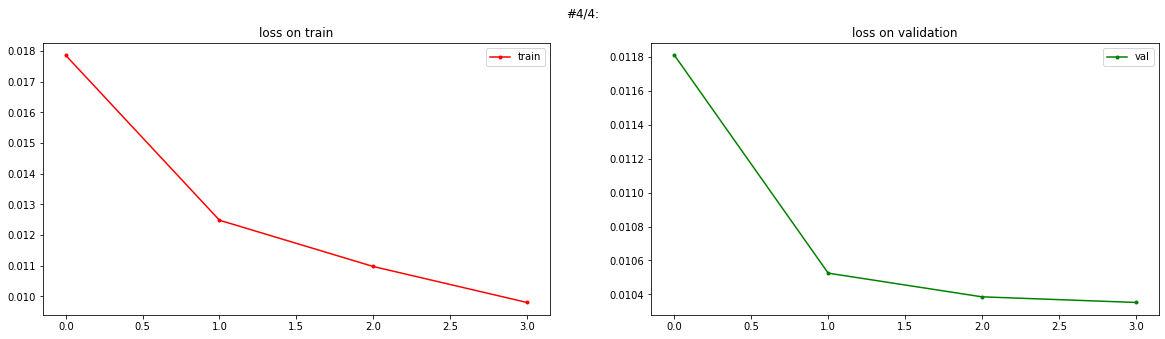

Train loss: 0.009801663356870034; Val loss: 0.01035192168986424; Val score: 0.9995528960210881


In [10]:
model = train_model(model, train, plotting=True)

In [11]:
torch.save(model.state_dict(), "model_pointnet.pth")

In [12]:
score, preds = predict(model, test)

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/729 [00:00<?, ?it/s]

In [13]:
print("ROC-AUC score: ", score)

ROC-AUC score:  0.9990379575032312


In [14]:
scene = test.sort_values(by="scene_id").query("scene_id == 2")
filtered_mask = preds.argmax(axis=1)[:len(scene)] == 1

In [15]:
filtered_scene = scene[filtered_mask]

fig = go.Figure(layout=EQUAL_ASPECT_RATIO_LAYOUT)
fig.add_scatter3d(**{
    'x': filtered_scene.x,
    'y': filtered_scene.y,
    'z': filtered_scene.z,
    'mode': 'markers',
    'marker': {
        'size': 1,
        'color': color(filtered_scene.label, 'seismic'),
    },
    'text': filtered_scene.label
})

py.iplot(fig)

In [16]:
filtered_scene = scene[~filtered_mask]

fig = go.Figure(layout=EQUAL_ASPECT_RATIO_LAYOUT)
fig.add_scatter3d(**{
    'x': filtered_scene.x,
    'y': filtered_scene.y,
    'z': filtered_scene.z,
    'mode': 'markers',
    'marker': {
        'size': 1,
        'color': color(filtered_scene.label, 'seismic'),
    },
    'text': filtered_scene.label
})

py.iplot(fig)